In [1]:
from mxnet import gluon
from mxnet import ndarray as nd

def transform(data, label):
    return data.astype('float32')/255, label.astype('float32')
mnist_train = gluon.data.vision.FashionMNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.FashionMNIST(train=False, transform=transform)

In [2]:
data, label = mnist_train[0]
('example shape: ', data.shape, 'label:', label)

('example shape: ', (28, 28, 1), 'label:', 2.0)

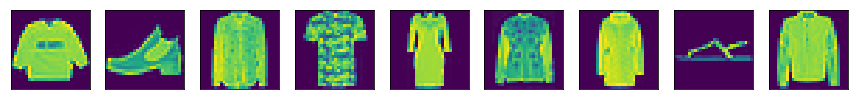

['pullover', 'ankle boot', 'shirt', 't-shirt', 'dress,', 'coat', 'coat', 'sandal', 'coat']


In [3]:
import matplotlib.pyplot as plt

def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28, 28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()

def get_text_labels(label):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in label]

data, label = mnist_train[0:9]
show_images(data)
print(get_text_labels(label))

In [4]:
batch_size = 256
train_data = gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)
test_data = gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

In [5]:

num_inputs = 784
num_outputs = 10

W = nd.random_normal(shape=(num_inputs, num_outputs))
b = nd.random_normal(shape=num_outputs)

params = [W, b]

In [6]:
for param in params:
    param.attach_grad()

In [7]:
from mxnet import nd
def softmax(X):
    exp = nd.exp(X)
    # 假设exp是矩阵，这里对行进行求和，并要求保留axis 1，
    # 就是返回 (nrows, 1) 形状的矩阵
    partition = exp.sum(axis=1, keepdims=True)
    return exp / partition

In [11]:
X = nd.random_normal(shape=(2,5))
print(X)
X_prob = softmax(X)
print(X_prob)
print(X_prob.sum(axis=1))


[[ 0.96285337  0.47811309  0.42453527  1.72885859 -0.3201234 ]
 [ 1.72286665  2.06755948 -0.9782294   0.47031024 -1.71680105]]
<NDArray 2x5 @cpu(0)>

[[ 0.21607825  0.13307334  0.12613119  0.46481797  0.05989924]
 [ 0.35758513  0.50475156  0.02400537  0.10218829  0.01146967]]
<NDArray 2x5 @cpu(0)>

[ 1.  1.]
<NDArray 2 @cpu(0)>


In [12]:
def net(X):
    return softmax(nd.dot(X.reshape((-1,num_inputs)), W) + b)

In [13]:
def cross_entropy(yhat, y):
    return - nd.pick(nd.log(yhat), y)

In [14]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

In [15]:
def evaluate_accuracy(data_iterator, net):
    acc = 0.
    for data, label in data_iterator:
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

In [16]:
evaluate_accuracy(test_data, net)

0.10048828125000001

In [17]:

import sys
sys.path.append('..')
from utils import SGD
from mxnet import autograd

learning_rate = .1

for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label)
        loss.backward()
        # 将梯度做平均，这样学习率会对batch size不那么敏感
        SGD(params, learning_rate/batch_size)

        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)

    test_acc = evaluate_accuracy(test_data, net)
    print("Epoch %d. Loss: %f, Train acc %f, Test acc %f" % (
        epoch, train_loss/len(train_data), train_acc/len(train_data), test_acc))

Epoch 0. Loss: 3.703330, Train acc 0.437245, Test acc 0.572168
Epoch 1. Loss: 1.894211, Train acc 0.619736, Test acc 0.645410
Epoch 2. Loss: 1.572477, Train acc 0.668695, Test acc 0.683301
Epoch 3. Loss: 1.402636, Train acc 0.696155, Test acc 0.699023
Epoch 4. Loss: 1.289888, Train acc 0.713154, Test acc 0.716016


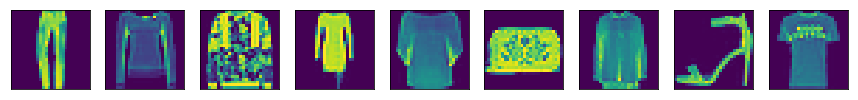

true labels
['trouser', 'pullover', 'pullover', 'dress,', 'pullover', 'bag', 'shirt', 'sandal', 't-shirt']
predicted labels
['trouser', 'pullover', 'shirt', 'coat', 'bag', 'bag', 't-shirt', 'sandal', 't-shirt']


In [19]:
data, label = mnist_test[1:10]
show_images(data)
print('true labels')
print(get_text_labels(label))

predicted_labels = net(data).argmax(axis=1)
print('predicted labels')
print(get_text_labels(predicted_labels.asnumpy()))